# WebDataset integration using External Source
In this notebook is an example of how one may combine the [webdataset](https://github.com/webdataset/webdataset) with a DALI pipeline, using an external source operator

## Introduction
### Data Representation
Web Dataset is a dataset representation that heavily optimizes networked accessed storage performance. At its simplest, it stores the whole dataset in one tarball file, where each sample is represented by one or more entries with the same name but different extensions. This approach improves drive access caching in RAM, since the data is represented sequentially.

### Sharding
In order to improve distributed storage access and network data transfer, the webdataset employs a strategy called sharding. In this approach, the tarball holding the data is split into several smaller ones, called shards, which allows for fetching from several storage drives at once, and reduces the packet size that has to be transferred via the network.

## Sample Implementation
First, let's import the necessary modules and define the locations of the datasets that will be needed later.

`DALI_EXTRA_PATH` environment variable should point to the place where the data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded. Please make sure that the proper release tag is checked out.

The `tar_dataset_paths` holds the paths to the shards that will be loaded while showing and testing the webdataset loader.

`batch_size` is the common batch size for both loaders

In [1]:
import nvidia.dali.fn as fn
import nvidia.dali as dali
import nvidia.dali.types as types
import webdataset as wds
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import random
import tempfile
import tarfile

root_path = os.path.join(os.environ["DALI_EXTRA_PATH"], "db", "webdataset", "MNIST")
tar_dataset_paths = [os.path.join(root_path, data_file) 
                        for data_file in ["devel-0.tar", "devel-1.tar", "devel-2.tar"]]
batch_size = 1024

Next, let's extract the files that will later be used for comparing the file reader to our custom one.

The `folder_dataset_files` holds the paths to the files 

In [2]:
folder_dataset_root_dir = tempfile.TemporaryDirectory()
folder_dataset_dirs = [tempfile.TemporaryDirectory(dir=folder_dataset_root_dir.name) 
                     for dataset in tar_dataset_paths]
folder_dataset_tars = [tarfile.open(dataset) for dataset in tar_dataset_paths]

for folder_dataset_tar, folder_dataset_subdir in zip(folder_dataset_tars, folder_dataset_dirs):
    folder_dataset_tar.extractall(path=folder_dataset_subdir.name)

folder_dataset_files = [
    filepath
    for folder_dataset_subdir in folder_dataset_dirs
    for filepath in sorted(
        glob.glob(os.path.join(folder_dataset_subdir.name, "*.jpg")), 
        key=lambda s: int(s[s.rfind('/') + 1:s.rfind(".jpg")])
    )
]

The function below is used to later randomize the output from the dataset. The samples are first stored in a prefetch buffer, and then they're randomly yielded in a generator and replaced by a new sample.

In [3]:
def buffered_shuffle(generator_factory, initial_fill, seed):
    def buffered_shuffle_generator():
        nonlocal generator_factory, initial_fill, seed
        generator = generator_factory()
        # The buffer size must be positive
        assert(initial_fill > 0)

        # The buffer that will hold the randomized samples
        buffer = []

        # The random context for preventing side effects
        random_context = random.Random(seed)

        try:
            while len(buffer) < initial_fill: # Fills in the random buffer
                buffer.append(next(generator))

            while True: # Selects a random sample from the buffer and then fills it back in with a new one
                idx = random_context.randint(0, initial_fill-1)

                yield buffer[idx]
                buffer[idx] = None
                buffer[idx] = next(generator)

        except StopIteration: # When the generator runs out of the samples flushes our the buffer
            random_context.shuffle(buffer)

            while buffer:
                if buffer[-1] != None: # Prevents the one sample that was not filled from being duplicated
                    yield buffer[-1]
                buffer.pop()
    return buffered_shuffle_generator
            

The next function is used for padding the last batch with the last sample, in order to make it the same size as all the other ones.

In [4]:
def last_batch_padding(generator_factory, batch_size):
    def last_batch_padding_generator():
        nonlocal generator_factory, batch_size
        generator = generator_factory()
        in_batch_idx = 0
        last_item = None
        try:
            while True: # Keeps track of the last sample and the sample number mod batch_size
                if in_batch_idx >= batch_size:
                    in_batch_idx -= batch_size
                last_item = next(generator)
                in_batch_idx += 1
                yield last_item
        except StopIteration: # Repeats the last sample the necessary number of times
            while in_batch_idx < batch_size:
                yield last_item
                in_batch_idx += 1
    return last_batch_padding_generator

The final function collects all the data into batches in order to be able to have a variable length batch for the last sample

In [5]:
def collect_batches(generator_factory, batch_size):
    def collect_batches_generator():
        nonlocal generator_factory, batch_size
        generator = generator_factory()
        batch = []
        try:
            while True:
                batch.append(next(generator))
                if len(batch) == batch_size:
                    # Converts tuples of samples into tuples of batches of samples
                    yield tuple(map(list, zip(*batch)))
                    batch = []
        except StopIteration:
            if batch is not []:
                # Converts tuples of samples into tuples of batches of samples
                yield tuple(map(list, zip(*batch)))
    return collect_batches_generator

And finally the data loader, that configures and returns an [ExternalSource](https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/general/data_loading/external_input.html) node.

### Keyword Arguments:

`paths`: describes the paths to the file/files containing the webdataset, and can be formatted as any data accepted by the `WebDataset`

`extensions`: describes the extensions containing the data to be output through the dataset. By default, all image format extensions supported by `WebDataset` are used

`random_shuffle`: describes whether to shuffle the data read by the `WebDataset`

`initial_fill`: if `random_shuffle` is True describes the buffer size of the data shuffler. Set to 256 by default.

`seed`: describes the seed for shuffling the data. Useful for getting consistent results. Set to 0 by default

`pad_last_batch`: describes whether to pad the last batch with the final sample to match the regular batch size

`read_ahead`: describes whether to prefetch the data into the memory

`cycle`: can be either `"raise"`, in which case the data loader will throw StopIteration once it reaches the end of the data, in which case the user has to invoke `pipeline.reset()` before the next epoch, or `"quiet"`(Default), in which case it will keep looping over the data over and over

In [6]:
def read_webdataset(
    paths, 
    extensions=None,
    random_shuffle=False, 
    initial_fill=256, 
    seed=0,
    pad_last_batch=False,
    read_ahead=False,
    cycle="quiet"
):
    # Parsing the input data
    assert(cycle in {"quiet", "raise", "no"})
    if extensions == None:
        extensions = ';'.join(["jpg", "jpeg", "img", "image", "pbm", "pgm", "png"]) # All supported image formats
    if type(extensions) == str:
        extensions = (extensions,)
        
    # For later information for batch collection and padding
    max_batch_size = dali.pipeline.Pipeline.current().max_batch_size
    
    def webdataset_generator():
        bytes_np_mapper = (lambda data: np.frombuffer(data, dtype=np.uint8),)*len(extensions)
        dataset_instance = (wds.WebDataset(paths)
                            .to_tuple(*extensions)
                            .map_tuple(*bytes_np_mapper))
        
        for sample in dataset_instance:
            yield sample
            
    dataset = webdataset_generator
    
    # Adding the buffered shuffling
    if random_shuffle:
        dataset = buffered_shuffle(dataset, initial_fill, seed)
        
    # Adding the batch padding
    if pad_last_batch:
        dataset = last_batch_padding(dataset, max_batch_size)
    
    # Collecting the data into batches (possibly undefull)
    # Handled by a custom function only when `silent_cycle` is False
    if cycle != "quiet":
        dataset = collect_batches(dataset, max_batch_size)
    
    # Prefetching the data
    if read_ahead:
        dataset=list(dataset())
    
    return fn.external_source(
        source=dataset,
        num_outputs=len(extensions),
        batch=(cycle != "quiet"), # If `cycle` is "quiet" then batching is handled by the external source
        cycle=cycle,
        dtype=types.UINT8
    )

We also define a sample data augmentation function which decodes an image, applies a jitter to it and resizes it to 244x244.

In [7]:
def decode_augment(img, seed=0):
    img = fn.decoders.image(img)
    img = fn.jitter(img.gpu(), seed=seed)
    img = fn.resize(img, size=(224, 224))
    return img

## Usage presentation
Below we define the sample webdataset pipeline with our `external_source`-based loader, that just chains the previously defined reader and augmentation function together.

In [8]:
@dali.pipeline_def(batch_size=batch_size, num_threads=4, device_id=0)
def webdataset_pipeline(
    paths,
    random_shuffle=False, 
    initial_fill=256,
    seed=0,
    pad_last_batch=False,
    read_ahead=False,
    cycle="quiet"
):
    img, label = read_webdataset(paths=paths, 
                                 extensions=("jpg", "cls"),
                                 random_shuffle=random_shuffle,
                                 initial_fill=initial_fill,
                                 seed=seed,
                                 pad_last_batch=pad_last_batch,
                                 read_ahead=read_ahead,
                                 cycle=cycle)
    return decode_augment(img, seed=seed), label

The pipeline can then be build with the desired arguments passed through to the data loader

In [9]:
pipeline = webdataset_pipeline(
    tar_dataset_paths,   # Paths for the sharded dataset
    random_shuffle=True, # Random buffered shuffling on
    pad_last_batch=False, # Last batch is filled to the full size
    read_ahead=False,
    cycle="raise")     # All the data is preloaded into the memory
pipeline.build()

And executed, printing the example image using matplotlib

1


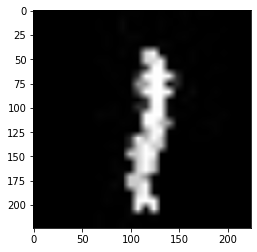

In [10]:
img, c = pipeline.run() # If StopIteration is raised, use pipeline.reset() to start a new epoch
img = img.as_cpu()
print(int(bytes(c.as_array()[0]))) # Conversion from an array of bytes back to bytes and then to int
plt.imshow(img.as_array()[0])
plt.show()

## Checking consistency
Here we will check if the custom pipeline for the webdataset matches an equivalent pipeline reading the files from an untarred directory, with `fn.readers.file` reader.

First let's define the pipeline to compare against. This is the same pipeline as the one for the webdataset, but instead uses the `fn.readers.file` reader.

In [11]:
@dali.pipeline_def(batch_size=batch_size, num_threads=4, device_id=0)
def file_pipeline(files):
    img, _ = fn.readers.file(files=files)
    return decode_augment(img)

Then let's instantiate and build both pipelines

In [12]:
webdataset_pipeline_instance = webdataset_pipeline(tar_dataset_paths)
webdataset_pipeline_instance.build()
file_pipeline_instance = file_pipeline(folder_dataset_files)
file_pipeline_instance.build()


And run the comparison loop.

In [13]:
# The number of batches to sample between the two pipelines
num_batches = 10

for _ in range(num_batches):
    webdataset_pipeline_threw_exception = False
    file_pipeline_threw_exception = False
    
    # Try running the webdataset pipeline and check if it has run out of the samples
    try:
        web_img, _ = webdataset_pipeline_instance.run()
    except StopIteration:
        webdataset_pipeline_threw_exception = True
    
    # Try running the file pipeline and check if it has run out of the samples
    try:
        (file_img,) = file_pipeline_instance.run()
    except StopIteration:
        file_pipeline_threw_exception = True
    
    # In case of different number of batches
    assert(webdataset_pipeline_threw_exception==file_pipeline_threw_exception)

    web_img = web_img.as_cpu().as_array()
    file_img = file_img.as_cpu().as_array()

    # In case the pipelines give different outputs
    np.testing.assert_equal(web_img, file_img)
else:
    print("No difference found!")

No difference found!
